In [112]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import os, sys
import keras, sklearn
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import concatenate
import matplotlib.pyplot as plt
import pandas
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# MACROS
FEATURES_IN_TRACK = 5
FEATURES_IN_TOWER = 8
JET_NUM_OF_PROPERTIES = 3
TRACKS_IN_JET = 50
TOWERS_IN_JET = 50
EPOCHS = 5
BATCH_SIZE = 400
LEARNING_RATE = 1e-5
EARLY_STOPPING_PATIENCE = 10
DARK_JETS_REL_AMOUNT = 0.0001
THRESHOLD = 0.99

In [ ]:
def lstm_model():
  input_1 = tf.keras.layers.Input(shape=[TRACKS_IN_JET, FEATURES_IN_TRACK+FEATURES_IN_TOWER], name='track_sequential_samples')
  #input_2 = tf.keras.layers.Input(shape=[TOWERS_IN_JET, FEATURES_IN_TOWER], name='tower_sequential_samples')
  #input_3 = tf.keras.layers.Input(shape=(JET_NUM_OF_PROPERTIES,), name='jet_general_properties')

  #conc1 = tf.keras.layers.concatenate([input_1, input_2], axis=2)
  model = tf.keras.layers.LSTM(32, activation='elu', input_shape=(TRACKS_IN_JET, FEATURES_IN_TRACK+FEATURES_IN_TOWER), return_sequences=True)(input_1)
  model = tf.keras.layers.LSTM(16, activation='elu', return_sequences=False)(model)
  model = tf.keras.layers.RepeatVector(TRACKS_IN_JET)(model)
  model = tf.keras.layers.LSTM(16, activation='elu', return_sequences=True)(model)
  model = tf.keras.layers.LSTM(32, activation='elu', return_sequences=True)(model)
  model = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(FEATURES_IN_TRACK+FEATURES_IN_TOWER))(model)

  return tf.keras.Model(inputs=[input_1], outputs=model)

In [ ]:
model = lstm_model()

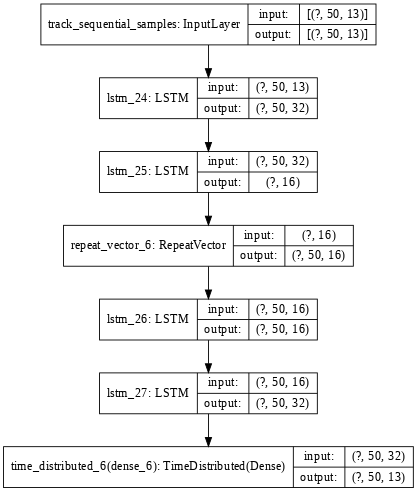

In [116]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
def load_data_tracks():
  PATH_dark = '/content/drive/My Drive/yevgeny_project/AutoEncoder/DarkJets/Tracks.csv'
  PATH_qcd = '/content/drive/My Drive/yevgeny_project/AutoEncoder/QCDJets/Tracks.csv'
  tableframeDark = pandas.read_csv(PATH_dark, header=None)
  tableDark = tableframeDark.values
  tableDark = tableDark.astype('float32')

  tableframeQCD = pandas.read_csv(PATH_qcd, header=None)
  tableQCD = tableframeQCD.values
  tableQCD = tableQCD.astype('float32')

  return tableDark, tableQCD

In [ ]:
def load_data_towers():
  PATH_dark = '/content/drive/My Drive/yevgeny_project/AutoEncoder/DarkJets/Towers.csv'
  PATH_qcd = '/content/drive/My Drive/yevgeny_project/AutoEncoder/QCDJets/Towers.csv'
  tableframeDark = pandas.read_csv(PATH_dark, header=None)
  tableDark = tableframeDark.values
  tableDark = tableDark.astype('float32')

  tableframeQCD = pandas.read_csv(PATH_qcd, header=None)
  tableQCD = tableframeQCD.values
  tableQCD = tableQCD.astype('float32')

  return tableDark, tableQCD

In [ ]:
def load_data_jets():
  PATH_dark = '/content/drive/My Drive/yevgeny_project/AutoEncoder/DarkJets/Jets.csv'
  PATH_qcd = '/content/drive/My Drive/yevgeny_project/AutoEncoder/QCDJets/Jets.csv'
  tableframeDark = pandas.read_csv(PATH_dark, header=None)
  tableDark = tableframeDark.values
  tableDark = tableDark.astype('float32')

  tableframeQCD = pandas.read_csv(PATH_qcd, header=None)
  tableQCD = tableframeQCD.values
  tableQCD = tableQCD.astype('float32')

  return tableDark, tableQCD

In [ ]:
def reshape_table_tracks(table_track):
  total_tracks_num = np.size(table_track,0)
  total_jets_num = int(total_tracks_num/TRACKS_IN_JET)
  table_track = table_track.reshape(total_jets_num, TRACKS_IN_JET, FEATURES_IN_TRACK)
  return table_track

In [ ]:
def reshape_table_towers(table_tower):
  total_towers_num = np.size(table_tower,0)
  total_jets_num = int(total_towers_num/TOWERS_IN_JET)
  table_tower = table_tower.reshape(total_jets_num, TOWERS_IN_JET, FEATURES_IN_TOWER)
  return table_tower

In [ ]:
def concatenate_scale_data(tableDark, tableQCD):
  #dark_result = np.where(tableDark == np.inf)
  #qcd_result = np.where(tableQCD == np.inf)
  #print(dark_result, qcd_result)
  tableAll = np.concatenate((tableDark, tableQCD), axis=0)
  print(tableAll.shape)
  tableAll = RobustScaler().fit_transform(tableAll)
  return tableAll

In [ ]:
def create_databases(): # This function loads the raw data ad returns data ready as inputs
  # load data
  table_track_dark, table_track_qcd = load_data_tracks()
  table_tower_dark, table_tower_qcd = load_data_towers()
  table_jet_dark, table_jet_qcd = load_data_jets()

  # convert to numpy arrays
  table_track_dark = np.array(table_track_dark)
  table_track_qcd = np.array(table_track_qcd)

  table_tower_dark = np.array(table_tower_dark)
  table_tower_qcd = np.array(table_tower_qcd)

  table_jet_dark = np.array(table_jet_dark)
  table_jet_qcd = np.array(table_jet_qcd)

  # choose how many dark jets to insert
  num_of_dark_jets = np.size(table_jet_dark,0)
  num_of_qcd_jets = np.size(table_jet_qcd,0)
  num_of_used_dark_jets = np.floor(DARK_JETS_REL_AMOUNT * num_of_qcd_jets).astype(np.int32)
  print(num_of_used_dark_jets)

  # create label databases
  label_dark = [True]*num_of_used_dark_jets
  label_qcd = [False]*num_of_qcd_jets
  label_dark = np.array(label_dark)
  label_qcd = np.array(label_qcd)

  # concatenate and scale
  TrackDb = concatenate_scale_data(table_track_dark[0:(num_of_used_dark_jets*TRACKS_IN_JET),:], table_track_qcd[0:(num_of_qcd_jets*TRACKS_IN_JET),:])
  TowerDb = concatenate_scale_data(table_tower_dark[0:(num_of_used_dark_jets*TOWERS_IN_JET),:], table_tower_qcd[0:(num_of_qcd_jets*TOWERS_IN_JET),:])
  JetDb = concatenate_scale_data(table_jet_dark[0:num_of_used_dark_jets,:], table_jet_qcd)
  LabelDb = np.append(label_dark, label_qcd)

  # reshape to 3D LSTM input
  TrackDb = reshape_table_tracks(TrackDb)
  TowerDb = reshape_table_towers(TowerDb)

  return TrackDb, TowerDb, JetDb, LabelDb 

In [124]:
TrackDb, TowerDb, JetDb, LabelDb  = create_databases()

# spilt datasets (and also shuffle) to train (60%), validation (20%) and test (20%) 
TrackDb_train, TrackDb_val, TowerDb_train, TowerDb_val, JetDb_train, JetDb_val, LabelDb_train, LabelDb_val = train_test_split(TrackDb, TowerDb, JetDb, LabelDb, test_size=0.2)
TrackDb_train, TrackDb_test, TowerDb_train, TowerDb_test, JetDb_train, JetDb_test, LabelDb_train, LabelDb_test = train_test_split(TrackDb_train, TowerDb_train, JetDb_train, LabelDb_train, test_size=0.25)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


9
(array([], dtype=int64), array([], dtype=int64)) (array([  70550,  686450, 2991050, 3001250, 3001251, 3330550, 4207350,
       4207351, 4207352, 4207353, 4207354, 4511950, 4511951, 4511952,
       4990950, 4990951]), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))
(4999600, 5)


ValueError: ignored

In [ ]:
# create data frames for the jets for anomalies checks
trainDF = pandas.DataFrame(data=LabelDb_train, columns=['Label'])
testDF = pandas.DataFrame(data=LabelDb_test, columns=['Label'])

In [ ]:
def plot_loss(hist):
  plt.figure
  plt.semilogy(hist.epoch,  hist.history['loss'], label='Train ')
  plt.semilogy(hist.epoch,  hist.history['val_loss'], label='Validation ', linestyle="--")

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [ ]:
# compile
opt = tf.keras.optimizers.Adam(LEARNING_RATE)
loss_L1 = tf.keras.losses.MeanAbsoluteError()
model.compile(optimizer=opt,loss=loss_L1)

In [ ]:
# callbacks
#checkpoint = keras.callbacks.ModelCheckpoint('WandB.txt', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=EARLY_STOPPING_PATIENCE)

In [ ]:
#Train model
modelInputTrain = np.concatenate((TrackDb_train, TowerDb_train), axis = 2)
modelInputVal = np.concatenate((TrackDb_val, TowerDb_val), axis = 2) 
modelInputTest = np.concatenate((TrackDb_test, TowerDb_test), axis = 2) 
print(modelInputTrain.shape)
print(modelInputVal.shape)
history = model.fit(modelInputTrain, modelInputTrain, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(modelInputVal, modelInputVal), callbacks=[es])

In [ ]:
plot_loss(history)

In [ ]:
trainPred = model.predict(modelInputTrain)
#trainPred = modelInputTrain + np.random.random(modelInputTrain.shape) #untill model works

train_mae_loss = np.mean(np.mean(np.abs(trainPred - modelInputTrain), axis=2), axis=1) 
print(train_mae_loss.shape)

testPred = model.predict(modelInputTest)
#testPred = modelInputTest + np.random.random(modelInputTest.shape)

test_mae_loss = np.mean(np.mean(np.abs(testPred - modelInputTest), axis=2), axis=1)
print(test_mae_loss.shape)

In [ ]:
  plt.hist(train_mae_loss, label='Train Loss Distribution', bins = 40, linewidth=2, histtype='step')

In [ ]:
  plt.hist(test_mae_loss, label='Test Loss Distribution', bins = 40, linewidth=2, histtype='step')

In [ ]:
trainDF['Loss'] = train_mae_loss
threshold = np.quantile(trainDF['Loss'], THRESHOLD)
print(threshold)
trainDF['Threshold'] = threshold
trainDF['Anomaly'] = trainDF.Loss > trainDF.Threshold
trainAnomalies = trainDF[trainDF.Anomaly == True]
trainDarkJets = trainDF[trainDF.Label == True]

testDF['Loss'] = test_mae_loss
testDF['Threshold'] = threshold
testDF['Anomaly'] = testDF.Loss > testDF.Threshold
testAnomalies = trainDF[trainDF.Anomaly == True]
testDarkJets = testDF[testDF.Label == True]

print(trainAnomalies)
print(trainDarkJets)
print()
print(testAnomalies)
print(testDarkJets)